In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import tensorflow_hub as hub

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [3]:
unzip_data("archive.zip")

In [4]:
train_df = pd.read_csv("train.txt", sep=';', names=['text', 'target'])
test_df = pd.read_csv("test.txt", sep=';', names=['text', 'target'])
val_df = pd.read_csv("val.txt", sep=';', names=['text', 'target'])

In [5]:
print(len(train_df)) 
print(len(test_df))

16000
2000


In [6]:
train_df.target.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: target, dtype: int64

In [7]:
train_df_one_hot = pd.get_dummies(train_df, columns=["target"])
train_df_one_hot.head()

,text,target_anger,target_fear,target_joy,target_love,target_sadness,target_surprise
0,i didnt feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,0,1,0,0
4,i am feeling grouchy,1,0,0,0,0,0


In [8]:
len(train_df_one_hot)

16000

In [9]:
train_df_shuffled = train_df_one_hot.sample(frac = 1, random_state = 42)
train_df_shuffled.head()

,text,target_anger,target_fear,target_joy,target_love,target_sadness,target_surprise
8756,ive made it through a week i just feel beaten ...,0,0,0,0,1,0
4660,i feel this strategy is worthwhile,0,0,1,0,0,0
6095,i feel so worthless and weak what does he have...,0,0,0,0,1,0
304,i feel clever nov,0,0,1,0,0,0
8241,im moved in ive been feeling kind of gloomy,0,0,0,0,1,0


In [10]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled["text"].to_numpy(),
    train_df_shuffled[["target_anger", "target_fear", "target_joy", "target_sadness", "target_surprise"]].to_numpy(),
    test_size = 0.1,
    random_state = 42
)

In [11]:
train_df_shuffled[["target_anger", "target_fear", "target_joy", "target_sadness", "target_surprise"]].to_numpy()

array([[0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0]], dtype=uint8)

In [10]:
len(train_sentences)


14400

In [11]:
len(train_labels)

14400

In [12]:
train_labels[0]

array([1, 0, 0, 0, 0], dtype=uint8)

In [13]:
train_labels.shape

(14400, 5)

In [14]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(14400, 14400, 1600, 1600)

In [15]:
from helper_functions import create_tensorboard_callback

SAVE_DIR = "model_logs"

In [16]:
sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4", 
    input_shape = [],
    dtype = tf.string,
    trainable = False,
    name = "USE"
)

In [17]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation = "relu"),
    layers.Dense(5, activation = "softmax")
], name = "project_model")

In [18]:
model.summary()

Model: "project_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 256,830,981
Trainable params: 33,157
Non-trainable params: 256,797,824
_________________________________________________________________


In [19]:
model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [20]:
model_history = model.fit(
    train_sentences,
    train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "tf_hub_sentence_encoder")]
)

TensorBoard log 파일들은 model_logs/tf_hub_sentence_encoder/20211210-001602에 저장했습니다.
Epoch 1/5
450/450 [==============================] - 4s 6ms/step - loss: 0.3889 - accuracy: 0.5169 - val_loss: 0.3056 - val_accuracy: 0.6275
Epoch 2/5
450/450 [==============================] - 2s 5ms/step - loss: 0.2990 - accuracy: 0.6212 - val_loss: 0.2814 - val_accuracy: 0.6469
Epoch 3/5
450/450 [==============================] - 2s 5ms/step - loss: 0.2836 - accuracy: 0.6381 - val_loss: 0.2715 - val_accuracy: 0.6569
Epoch 4/5
450/450 [==============================] - 2s 5ms/step - loss: 0.2742 - accuracy: 0.6521 - val_loss: 0.2670 - val_accuracy: 0.6562
Epoch 5/5
450/450 [==============================] - 2s 5ms/step - loss: 0.2662 - accuracy: 0.6581 - val_loss: 0.2640 - val_accuracy: 0.6600


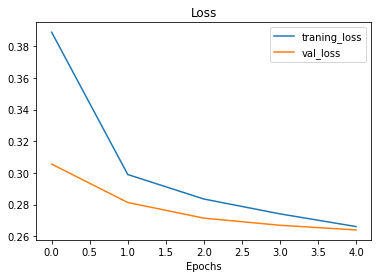

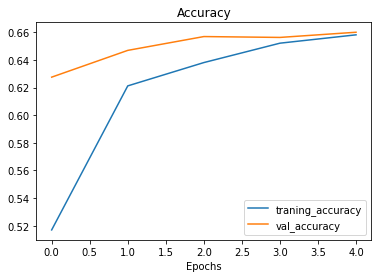

In [21]:
plot_loss_curves(model_history)

In [22]:
model.save("project_model.h5")